# BERT evaluation

Here I'll evaluate the BERT model on the test set.`

### DATA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
os.getcwd()

'/content'

In [5]:
test = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/test.csv')
test.head()

,id,text,rating
0,2,The final installment sees Sho Aikawa and Riki...,7
1,3,Homicide: The Movie proved to be a good wrap-u...,10
2,4,As a father of four in his forties I thought t...,7
3,5,A wonderful movie about people. I first saw Fo...,10
4,6,"Until today, I thought there only three people...",9


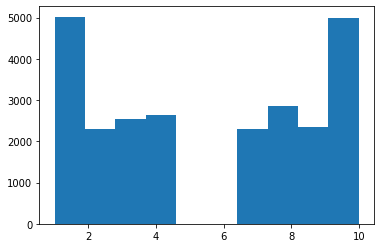

In [6]:
import matplotlib.pyplot as plt

plt.hist(test['rating'])
plt.show()

#### Load model

In [8]:
from transformers import BertForSequenceClassification, BertTokenizer

In [9]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [10]:
model = torch.load('/content/drive/MyDrive/models/bert_trained.pt', map_location=device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [ ]:
model = model.to(device)

In [12]:
for name, param in model.named_parameters():
  param.requires_grad = False

In [13]:
ratings = test.rating.values

test.rating.value_counts()

1     5022
10    4999
8     2850
4     2635
3     2541
9     2344
7     2307
2     2302
Name: rating, dtype: int64

In [14]:
ratings

array([ 7, 10,  7, ...,  1,  3,  2])

In [15]:
uni = test.rating.unique()
uni = np.sort(uni)
uni

array([ 1,  2,  3,  4,  7,  8,  9, 10])

In [16]:
map_uni = {val: idx for idx, val in enumerate(uni)}
map_uni

{1: 0, 2: 1, 3: 2, 4: 3, 7: 4, 8: 5, 9: 6, 10: 7}

#### Encoding

In [17]:
input_ids = []
attention_masks = []
reviews = test.text.values


for review in reviews:
    encoded_dict = tokenizer.encode_plus(
                        review,                     
                        add_special_tokens = True, 
                        truncation=True,
                        max_length = 512,
                        padding='max_length',         
                        return_attention_mask = True,  
                        return_tensors = 'pt',     
                   )
        
    input_ids.append(encoded_dict['input_ids'])   
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [18]:
ratings = [map_uni[rate] for rate in ratings]
labels = torch.tensor(ratings)

#### Datasets

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [20]:
test_dataset = TensorDataset(input_ids, attention_masks, labels, )

len(test_dataset)


25000

In [21]:
batch_size = 8

test_dataloader = DataLoader(
            test_dataset,  
            sampler = RandomSampler(test_dataset),
            batch_size = batch_size,
            num_workers=2
        )



In [22]:
import numpy as np
from tqdm import tqdm
import time
import copy

#### Evaluation

In [25]:
def test_model(model, test_dataloader):
    model.eval()

    since = time.perf_counter()

    running_loss = 0.0
    running_corrects = 0
    running_mse = 0.0
    running_error = 0.0
    all_preds = np.array([])
    all_labels = np.array([])
    errors = np.array([])

    with tqdm(test_dataloader, unit="batch", miniters=1) as tepoch:
        for iter, (input_ids, input_mask, labels) in enumerate(tepoch, start=1):
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            labels = labels.to(device)

            with torch.no_grad():  
                outputs = model(input_ids, 
                                token_type_ids=None, 
                                attention_mask=input_mask,
                                labels=labels,
                                )

                loss = outputs.loss
                running_loss += loss.item() * batch_size

                logits = outputs.logits
                log_soft = torch.softmax(logits, 1).detach().cpu()
                weighted = []

                for i, x in enumerate(log_soft.numpy()):
                    weighted.append([0])
                    for j, proba in enumerate(x):
                        weighted[i] += j * proba

                labels_cpu = labels.detach().cpu().numpy()
                error = 0.0
                for w_sum, label in zip(weighted, labels_cpu):
                    error += (label - w_sum) ** 2

                running_error += error
                _, preds = torch.max(torch.softmax(logits, 1), 1)

                running_corrects += torch.sum(preds==labels.data)
                running_accuracy = running_corrects / (iter * batch_size)
                running_mse = running_error / (iter * batch_size)
                tepoch.set_postfix(loss=loss.item(), accuracy=running_accuracy.item(), MSE=running_mse[0])

            labels = labels.to(torch.device('cpu'))
            preds = preds.to(torch.device('cpu'))

            labels_np = labels.detach().numpy()
            labels_np = np.reshape(labels_np, -1)
            all_labels = np.append(all_labels, labels_np, axis=0)

            preds_np = preds.detach().numpy()
            preds_np = np.reshape(preds_np, -1)
            all_preds = np.append(all_preds, preds_np, axis=0)

            errors = np.append(errors, error / batch_size, axis=0)

    test_loss = running_loss / len(test_dataloader.dataset)
    test_acc = running_corrects.double() / len(test_dataloader.dataset)

    print(f'test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}\n')

    print(f'Tested in {(time.perf_counter() - since):.1f}s')

    return all_preds, all_labels, errors

In [26]:
all_preds, all_labels, errors = test_model(model, test_dataloader)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

100%|██████████| 3125/3125 [13:51<00:00,  3.76batch/s, MSE=1.43, accuracy=0.518, loss=0.879]

test_loss: 1.2150 test_acc: 0.5184

Tested in 831.9s


### RESULTS

              precision    recall  f1-score   support

           1       0.68      0.75      0.71      5022
           2       0.45      0.17      0.25      2302
           3       0.35      0.35      0.35      2541
           4       0.43      0.57      0.49      2635
           7       0.50      0.39      0.44      2307
           8       0.38      0.41      0.40      2850
           9       0.47      0.14      0.21      2344
          10       0.58      0.80      0.67      4999

    accuracy                           0.52     25000
   macro avg       0.48      0.45      0.44     25000
weighted avg       0.51      0.52      0.49     25000



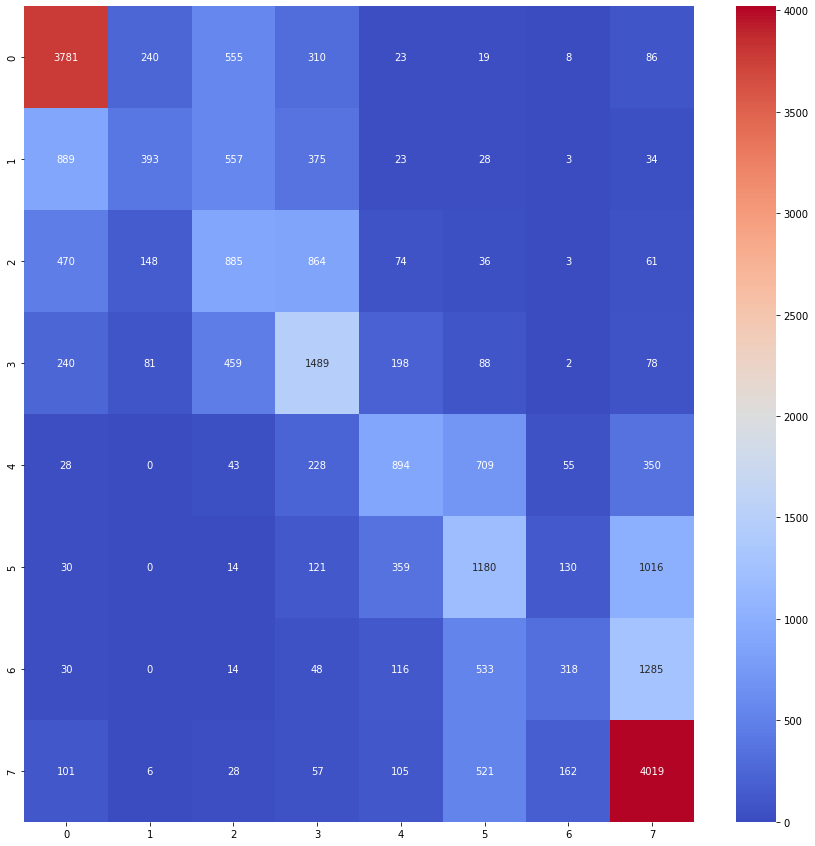

In [27]:
targets = [str(key) for key in map_uni.keys()]
print(classification_report(all_labels, all_preds, target_names=targets))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.show()

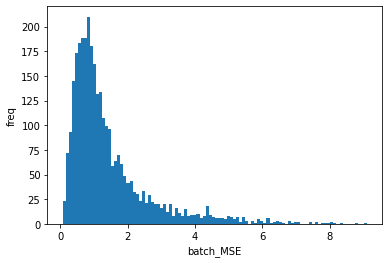

In [33]:
plt.hist(errors, bins=100)
plt.xlabel('batch_MSE')
plt.ylabel('freq')
plt.show()

Error seem to be distributed log-normally skewed to the right, which may speak for outliers or model not very good predicting hard cases. 

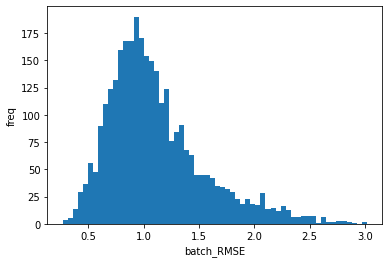

In [34]:
plt.hist(np.sqrt(errors), bins=60)
plt.xlabel('batch_RMSE')
plt.ylabel('freq')
plt.show()

In [32]:
pd.DataFrame(errors, columns=['batch_MSE']).describe()

,batch_MSE
count,3125.000000
mean,1.434202
std,1.237942
min,0.071729
25%,0.655921
50%,1.032241
75%,1.744952
max,9.101588


Model seems to be off by 1 point in 50% cases and 1.7 points in 75% cases, which is not too bad.